# Strict Test Evaluation Insights

Dieses Notebook analysiert die Resultate des strikten Tests allein basierend auf `03_organize_results/store/aggregated_results_strict_test.csv`. Es berechnet Word Error Rates (WER) für alle Modelle/Pipelines aus `info.py`, bestimmt Embedding Similarities für Whisper (`transcript_norm`) sowie ausgewählte Post-Editing-Systeme (`ger-spellcorr-base_strict_out`, `rules`, `rules-tx`) und zeigt Beispiele für besonders starke Verbesserungen bzw. Verschlechterungen.


In [60]:

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sentence_transformers import SentenceTransformer

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.max_colwidth = 200


In [61]:

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "03_organize_results").exists():
    RESULTS_DIR = PROJECT_ROOT / "03_organize_results"
elif PROJECT_ROOT.name == "03_organize_results":
    RESULTS_DIR = PROJECT_ROOT
else:
    raise FileNotFoundError(
        "Notebook bitte im Projekt-Root oder direkt im Ordner 03_organize_results starten."
    )

STORE_DIR = RESULTS_DIR / "store"
AGG_PATH = STORE_DIR / "aggregated_results_strict_test.csv"

if str(RESULTS_DIR) not in sys.path:
    sys.path.append(str(RESULTS_DIR))
from info import EXPERIMENTS

agg_df = pd.read_csv(AGG_PATH)
print(f"Rows: {len(agg_df):,}")
print(f"Columns: {len(agg_df.columns)}")
agg_df.head(3)


Rows: 21,866
Columns: 39


,clip_path,duration,sentence,transcript,json_path,confidence,sentence_source_x,dialect_region_x,canton_x,age_x,...,mt5-small_relaxed_oversampled_out,mt5-small_strict_out,mt5-small_strict_oversampled_out,ger-spellcorr-base_strict_out_conf_marked,tagger_out,ger-spellcorr-base_strict_twice,rules,tx-rules,rules-tx,tx-rules-tx
0,887b50f8-215b-4a1d-8f32-13516da6506f/73ca6c9b07dcd235d8aa2a08eef2d2642ae95f397efc3ae1e254f6b3b31a1042.mp3,6.156,"Ich bin der Meinung, dass ihr noch nicht alle Sparmöglichkeiten ausgeschöpft habt.","Ich bin der Meinung, dass er noch nicht alle Sparmöglichkeiten ausgeschöpft hat.",887b50f8-215b-4a1d-8f32-13516da6506f_73ca6c9b07dcd235d8aa2a08eef2d2642ae95f397efc3ae1e254f6b3b31a1042.json,0.898878,parliament,Bern,BE,sixties,...,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat,ich bin der meinung dass er noch nicht alle sparmöglichkeiten ausgeschöpft hat
1,31cab952-98eb-45cb-a243-c951519c5c40/3aca443138c80a3527a9876699c57a88afd18403e107aee84892a9e64e41b45c.mp3,5.148,Dann änderte sie ihre Meinung und verlangte die Tausender zurück.,Dann hat sie ihre Meinung geändert und den Tausender zurückverlangt.,31cab952-98eb-45cb-a243-c951519c5c40_3aca443138c80a3527a9876699c57a88afd18403e107aee84892a9e64e41b45c.json,0.901838,news_switz,Innerschweiz,LU,twenties,...,dann änderte sie ihre meinung und verlangte den tausender zurück,dann änderte sie ihre meinung und verlangte den tausender zurück,dann änderte sie ihre meinung und verlangte den tausender zurück,dann änderte sie ihre meinung und verlangte den tausenden zurück,dann habe sie ihre meinung geändert und den tausender zurück,dann änderte sie ihre meinung und verlangte den tausenden zurück,dann änderte sie ihre meinung und den tausender zurückverlangt,dann änderte sie ihre meinung und verlangte den tausenden zurück,dann änderte sie ihre meinung und verlangte tausende zurück,dann änderte sie ihre meinung und verlangte den tausenden zurück
2,8f16829d-1a64-4145-927c-d6738a07ea24/d472683940b4a42fed182c056d6d94a2390aa03d5c7e61fdb624bdaf1beb4036.mp3,2.952,Und neue Türen haben sich nicht geöffnet.,Und neue Türen haben sich nicht geöffnet.,8f16829d-1a64-4145-927c-d6738a07ea24_d472683940b4a42fed182c056d6d94a2390aa03d5c7e61fdb624bdaf1beb4036.json,0.898615,news_cultu,Basel,BS,thirties,...,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet,und neue türen haben sich nicht geöffnet



## Versuchs-Setup
Die Metainformationen aus `info.py` werden hier als Tabelle zusammengefasst und später für die Auswertung genutzt.


In [54]:

exp_records = []
for key, cfg in EXPERIMENTS.items():
    pred_key = key.replace("_out", "")
    exp_records.append({
        "pred_key": pred_key,
        "output_col": cfg["output_col"],
        "label": f"{cfg['model_family']} | {cfg['training_split']} | {'OS' if cfg['oversampled'] else 'std'}",
        "model_family": cfg["model_family"],
        "training_split": cfg["training_split"],
        "oversampled": cfg["oversampled"],
        "input_variant": cfg["input_variant"],
        "base_model": cfg["base_model"],
        "pipeline": " > ".join(cfg.get("pipeline", [])),
        "description": cfg["description"],
    })

experiments_df = pd.DataFrame(exp_records).set_index("pred_key")
experiments_df = experiments_df.sort_values(
    ["model_family", "training_split", "oversampled"], ascending=[True, True, False]
)

baseline_meta = {
    "pred_key": "whisper",
    "output_col": "transcript_norm",
    "label": "Whisper (Baseline)",
    "model_family": "Whisper",
    "training_split": "-",
    "oversampled": False,
    "input_variant": "transcript_norm",
    "base_model": "openai/whisper",
    "pipeline": "whisper",
    "description": "Originale Whisper-Transkripte (strict test)",
}

systems_df = pd.concat(
    [pd.DataFrame([baseline_meta]).set_index("pred_key"), experiments_df],
    axis=0,
    sort=False,
)
systems_df["wer_column"] = systems_df.index.map(lambda key: f"WER_{key}")

columns_to_show = [
    "label",
    "model_family",
    "training_split",
    "oversampled",
    "base_model",
    "pipeline",
    "output_col",
]
display(systems_df.loc[systems_df.index != "whisper", columns_to_show])


,label,model_family,training_split,oversampled,base_model,pipeline,output_col
pred_key,,,,,,,
byt5_all_oversampled,ByT5 | all | OS,ByT5,all,True,google/byt5-small,byt5_all_oversampled,byt5_all_oversampled_out
byt5_all,ByT5 | all | std,ByT5,all,False,google/byt5-small,byt5_all,byt5_all_out
byt5_relaxed_oversampled,ByT5 | relaxed | OS,ByT5,relaxed,True,google/byt5-small,byt5_relaxed_oversampled,byt5_relaxed_oversampled_out
byt5_relaxed,ByT5 | relaxed | std,ByT5,relaxed,False,google/byt5-small,byt5_relaxed,byt5_relaxed_out
byt5_strict_oversampled,ByT5 | strict | OS,ByT5,strict,True,google/byt5-small,byt5_strict_oversampled,byt5_strict_oversampled_out
byt5_strict,ByT5 | strict | std,ByT5,strict,False,google/byt5-small,byt5_strict,byt5_strict_out
tagger,EditTagger | relaxed/strict (je nach Setup – hier: finaler Tagger) | std,EditTagger,relaxed/strict (je nach Setup – hier: finaler Tagger),False,xlm-roberta-base,edit_tagger,tagger_out
ger-spellcorr-base_all_oversampled,ger-spellcorr | all | OS,ger-spellcorr,all,True,oliverguhr/spelling-correction-german-base,ger-spellcorr-base_all_oversampled,ger-spellcorr-base_all_oversampled_out
ger-spellcorr-base_all,ger-spellcorr | all | std,ger-spellcorr,all,False,oliverguhr/spelling-correction-german-base,ger-spellcorr-base_all,ger-spellcorr-base_all_out



## WER-Analyse
Die folgenden Helper berechnen WERs direkt aus `sentence_norm` (Referenz) und den jeweiligen Modelloutputs.


In [55]:

from typing import Dict

REF_COLUMN = "sentence_norm"
BASELINE_KEY = "whisper"


def _tokenize(text: object) -> tuple[str, ...]:
    if not isinstance(text, str):
        return tuple()
    return tuple(text.strip().split())


def word_error_rate(reference: object, hypothesis: object) -> float:
    ref_tokens = _tokenize(reference)
    hyp_tokens = _tokenize(hypothesis)
    n = len(ref_tokens)
    m = len(hyp_tokens)
    if n == 0:
        return 0.0 if m == 0 else 1.0
    prev_row = list(range(m + 1))
    for i in range(1, n + 1):
        current = [i] + [0] * m
        ref_token = ref_tokens[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ref_token == hyp_tokens[j - 1] else 1
            current[j] = min(
                current[j - 1] + 1,
                prev_row[j] + 1,
                prev_row[j - 1] + cost,
            )
        prev_row = current
    distance = prev_row[m]
    return distance / max(n, 1)


WER_CACHE: Dict[str, pd.Series] = {}


def get_wer_series(pred_key: str) -> pd.Series:
    if pred_key in WER_CACHE:
        return WER_CACHE[pred_key]
    meta = systems_df.loc[pred_key]
    column = meta["output_col"]
    refs = agg_df[REF_COLUMN].fillna("").astype(str).tolist()
    hyps = agg_df[column].fillna("").astype(str).tolist()
    wers = np.fromiter(
        (word_error_rate(r, h) for r, h in zip(refs, hyps)),
        dtype=np.float32,
        count=len(refs),
    )
    series = pd.Series(wers, index=agg_df.index, name=meta["wer_column"])
    WER_CACHE[pred_key] = series
    agg_df[meta["wer_column"]] = series
    return series


def summarize_wer() -> pd.DataFrame:
    rows = []
    baseline_meta = systems_df.loc[BASELINE_KEY]
    baseline = get_wer_series(BASELINE_KEY)
    rows.append(
        {
            "pred_key": BASELINE_KEY,
            "label": baseline_meta["label"],
            "model_family": baseline_meta["model_family"],
            "training_split": baseline_meta["training_split"],
            "oversampled": baseline_meta["oversampled"],
            "mean_wer": baseline.mean(),
            "median_wer": baseline.median(),
            "std_wer": baseline.std(),
            "delta_vs_whisper": 0.0,
            "share_improved": np.nan,
        }
    )
    for key, meta in systems_df.drop(BASELINE_KEY).iterrows():
        series = get_wer_series(key)
        delta = baseline - series
        rows.append(
            {
                "pred_key": key,
                "label": meta["label"],
                "model_family": meta["model_family"],
                "training_split": meta["training_split"],
                "oversampled": meta["oversampled"],
                "mean_wer": series.mean(),
                "median_wer": series.median(),
                "std_wer": series.std(),
                "delta_vs_whisper": delta.mean(),
                "share_improved": (delta > 0).mean(),
            }
        )
    summary = pd.DataFrame(rows)
    return summary.sort_values("mean_wer")


wer_summary = summarize_wer()
wer_summary


,pred_key,label,model_family,training_split,oversampled,mean_wer,median_wer,std_wer,delta_vs_whisper,share_improved
22,rules-tx,pipeline | strict | std,pipeline,strict,False,0.115130,0.083333,0.142259,0.051086,0.315147
23,tx-rules-tx,pipeline | strict | std,pipeline,strict,False,0.121208,0.090909,0.147104,0.045008,0.303485
24,tx-rules,pipeline | strict (für den ger-spellcorr-Teil) | std,pipeline,strict (für den ger-spellcorr-Teil),False,0.124184,0.090909,0.147197,0.042032,0.301747
25,rules,rules | strict (Regeln wurden auf strict_train gelernt) | std,rules,strict (Regeln wurden auf strict_train gelernt),False,0.132560,0.111111,0.144073,0.033656,0.224870
14,ger-spellcorr-base_strict_conf_marked,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.139828,0.111111,0.155627,0.026388,0.233010
13,ger-spellcorr-base_strict,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.140413,0.111111,0.154746,0.025803,0.224046
11,ger-spellcorr-base_relaxed,ger-spellcorr | relaxed | std,ger-spellcorr,relaxed,False,0.141041,0.111111,0.156539,0.025175,0.228208
15,ger-spellcorr-base_strict_twice,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.141213,0.111111,0.155668,0.025003,0.224092
9,ger-spellcorr-base_all,ger-spellcorr | all | std,ger-spellcorr,all,False,0.142097,0.111111,0.160200,0.024119,0.232141
6,byt5_strict,ByT5 | strict | std,ByT5,strict,False,0.143229,0.111111,0.154095,0.022987,0.195600


In [56]:
print(wer_summary)

                                  pred_key  \
22                                rules-tx   
23                             tx-rules-tx   
24                                tx-rules   
25                                   rules   
14   ger-spellcorr-base_strict_conf_marked   
13               ger-spellcorr-base_strict   
11              ger-spellcorr-base_relaxed   
15         ger-spellcorr-base_strict_twice   
9                   ger-spellcorr-base_all   
6                              byt5_strict   
10  ger-spellcorr-base_relaxed_oversampled   
12   ger-spellcorr-base_strict_oversampled   
4                             byt5_relaxed   
2                                 byt5_all   
8       ger-spellcorr-base_all_oversampled   
5                  byt5_strict_oversampled   
3                 byt5_relaxed_oversampled   
1                     byt5_all_oversampled   
21                        mt5-small_strict   
17                           mt5-small_all   
19                       mt5-small

In [62]:

from typing import Dict

REF_COLUMN = "sentence_norm"
BASELINE_KEY = "whisper"


def _tokenize(text: object) -> tuple[str, ...]:
    if not isinstance(text, str):
        return tuple()
    return tuple(text.strip().split())


def word_error_rate(reference: object, hypothesis: object) -> float:
    ref_tokens = _tokenize(reference)
    hyp_tokens = _tokenize(hypothesis)
    n = len(ref_tokens)
    m = len(hyp_tokens)
    if n == 0:
        return 0.0 if m == 0 else 1.0
    prev_row = list(range(m + 1))
    for i in range(1, n + 1):
        current = [i] + [0] * m
        ref_token = ref_tokens[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ref_token == hyp_tokens[j - 1] else 1
            current[j] = min(
                current[j - 1] + 1,
                prev_row[j] + 1,
                prev_row[j - 1] + cost,
            )
        prev_row = current
    distance = prev_row[m]
    return distance / max(n, 1)


WER_CACHE: Dict[str, pd.Series] = {}


def get_wer_series(pred_key: str) -> pd.Series:
    if pred_key in WER_CACHE:
        return WER_CACHE[pred_key]
    meta = systems_df.loc[pred_key]
    column = meta["output_col"]
    refs = agg_df[REF_COLUMN].fillna("").astype(str).tolist()
    hyps = agg_df[column].fillna("").astype(str).tolist()
    wers = np.fromiter(
        (word_error_rate(r, h) for r, h in zip(refs, hyps)),
        dtype=np.float32,
        count=len(refs),
    )
    series = pd.Series(wers, index=agg_df.index, name=meta["wer_column"])
    WER_CACHE[pred_key] = series
    agg_df[meta["wer_column"]] = series
    return series


def summarize_wer() -> pd.DataFrame:
    rows = []
    baseline_meta = systems_df.loc[BASELINE_KEY]
    baseline = get_wer_series(BASELINE_KEY)

    # Baseline-Kennwerte einmal berechnen
    baseline_mean = baseline.mean()
    baseline_median = baseline.median()

    rows.append(
        {
            "pred_key": BASELINE_KEY,
            "label": baseline_meta["label"],
            "model_family": baseline_meta["model_family"],
            "training_split": baseline_meta["training_split"],
            "oversampled": baseline_meta["oversampled"],
            "mean_wer": baseline_mean,
            "median_wer": baseline_median,
            "std_wer": baseline.std(),
            "delta_vs_whisper": 0.0,
            "share_improved": np.nan,
            # Verbesserungen ggü. sich selbst = 0 %
            "improvement_mean_wer_pct": 0.0,
            "improvement_median_wer_pct": 0.0,
        }
    )

    for key, meta in systems_df.drop(BASELINE_KEY).iterrows():
        series = get_wer_series(key)
        mean_wer = series.mean()
        median_wer = series.median()

        delta = baseline - series  # positiv = besser als Whisper

        # Schutz vor Division durch 0 (falls Baseline-WER theoretisch 0 wäre)
        if baseline_mean > 0:
            improvement_mean_wer_pct = (baseline_mean - mean_wer) / baseline_mean * 100
        else:
            improvement_mean_wer_pct = np.nan

        if baseline_median > 0:
            improvement_median_wer_pct = (baseline_median - median_wer) / baseline_median * 100
        else:
            improvement_median_wer_pct = np.nan

        rows.append(
            {
                "pred_key": key,
                "label": meta["label"],
                "model_family": meta["model_family"],
                "training_split": meta["training_split"],
                "oversampled": meta["oversampled"],
                "mean_wer": mean_wer,
                "median_wer": median_wer,
                "std_wer": series.std(),
                "delta_vs_whisper": delta.mean(),
                "share_improved": (delta > 0).mean(),
                "improvement_mean_wer_pct": improvement_mean_wer_pct,
                "improvement_median_wer_pct": improvement_median_wer_pct,
            }
        )

    summary = pd.DataFrame(rows)
    return summary.sort_values("mean_wer")


wer_summary = summarize_wer()
wer_summary


,pred_key,label,model_family,training_split,oversampled,mean_wer,median_wer,std_wer,delta_vs_whisper,share_improved,improvement_mean_wer_pct,improvement_median_wer_pct
22,rules-tx,pipeline | strict | std,pipeline,strict,False,0.115130,0.083333,0.142259,0.051086,0.315147,30.734774,41.666668
23,tx-rules-tx,pipeline | strict | std,pipeline,strict,False,0.121208,0.090909,0.147104,0.045008,0.303485,27.078026,36.363636
24,tx-rules,pipeline | strict (für den ger-spellcorr-Teil) | std,pipeline,strict (für den ger-spellcorr-Teil),False,0.124184,0.090909,0.147197,0.042032,0.301747,25.287539,36.363636
25,rules,rules | strict (Regeln wurden auf strict_train gelernt) | std,rules,strict (Regeln wurden auf strict_train gelernt),False,0.132560,0.111111,0.144073,0.033656,0.224870,20.248159,22.222225
14,ger-spellcorr-base_strict_conf_marked,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.139828,0.111111,0.155627,0.026388,0.233010,15.875755,22.222225
13,ger-spellcorr-base_strict,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.140413,0.111111,0.154746,0.025803,0.224046,15.523548,22.222225
11,ger-spellcorr-base_relaxed,ger-spellcorr | relaxed | std,ger-spellcorr,relaxed,False,0.141041,0.111111,0.156539,0.025175,0.228208,15.145829,22.222225
15,ger-spellcorr-base_strict_twice,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.141213,0.111111,0.155668,0.025003,0.224092,15.042212,22.222225
9,ger-spellcorr-base_all,ger-spellcorr | all | std,ger-spellcorr,all,False,0.142097,0.111111,0.160200,0.024119,0.232141,14.510467,22.222225
6,byt5_strict,ByT5 | strict | std,ByT5,strict,False,0.143229,0.111111,0.154095,0.022987,0.195600,13.829759,22.222225


In [65]:
from typing import Dict

REF_COLUMN = "sentence_norm"
BASELINE_KEY = "whisper"


def _tokenize(text: object) -> tuple[str, ...]:
    if not isinstance(text, str):
        return tuple()
    return tuple(text.strip().split())


def word_error_rate(reference: object, hypothesis: object) -> float:
    ref_tokens = _tokenize(reference)
    hyp_tokens = _tokenize(hypothesis)
    n = len(ref_tokens)
    m = len(hyp_tokens)
    if n == 0:
        return 0.0 if m == 0 else 1.0
    prev_row = list(range(m + 1))
    for i in range(1, n + 1):
        current = [i] + [0] * m
        ref_token = ref_tokens[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ref_token == hyp_tokens[j - 1] else 1
            current[j] = min(
                current[j - 1] + 1,
                prev_row[j] + 1,
                prev_row[j - 1] + cost,
            )
        prev_row = current
    distance = prev_row[m]
    return distance / max(n, 1)


WER_CACHE: Dict[str, pd.Series] = {}


def get_wer_series(pred_key: str) -> pd.Series:
    if pred_key in WER_CACHE:
        return WER_CACHE[pred_key]
    meta = systems_df.loc[pred_key]
    column = meta["output_col"]
    refs = agg_df[REF_COLUMN].fillna("").astype(str).tolist()
    hyps = agg_df[column].fillna("").astype(str).tolist()
    wers = np.fromiter(
        (word_error_rate(r, h) for r, h in zip(refs, hyps)),
        dtype=np.float32,
        count=len(refs),
    )
    series = pd.Series(wers, index=agg_df.index, name=meta["wer_column"])
    WER_CACHE[pred_key] = series
    agg_df[meta["wer_column"]] = series
    return series


# -------------------------------------------------
# 1) Globale Tabelle (alle Samples)
# -------------------------------------------------
def summarize_wer_global() -> pd.DataFrame:
    rows = []

    # Baseline vorbereiten
    baseline_meta = systems_df.loc[BASELINE_KEY]
    baseline = get_wer_series(BASELINE_KEY)

    baseline_mean = baseline.mean()
    baseline_median = baseline.median()

    # Baseline-Zeile
    rows.append(
        {
            "pred_key": BASELINE_KEY,
            "label": baseline_meta["label"],
            "model_family": baseline_meta["model_family"],
            "training_split": baseline_meta["training_split"],
            "oversampled": baseline_meta["oversampled"],
            "mean_wer": baseline_mean,
            "median_wer": baseline_median,
            "std_wer": baseline.std(),
            "delta_vs_whisper": 0.0,
            "share_improved": np.nan,
            "improvement_mean_wer_pct": 0.0,
            "improvement_median_wer_pct": 0.0,
        }
    )

    # Alle anderen Systeme
    for key, meta in systems_df.drop(BASELINE_KEY).iterrows():
        series = get_wer_series(key)
        mean_wer = series.mean()
        median_wer = series.median()

        # globale Differenz vs Whisper
        delta = baseline - series  # > 0 = besser als Whisper

        # Prozentuale Verbesserung global
        if baseline_mean > 0:
            improvement_mean_wer_pct = (baseline_mean - mean_wer) / baseline_mean * 100
        else:
            improvement_mean_wer_pct = np.nan

        if baseline_median > 0:
            improvement_median_wer_pct = (baseline_median - median_wer) / baseline_median * 100
        else:
            improvement_median_wer_pct = np.nan

        rows.append(
            {
                "pred_key": key,
                "label": meta["label"],
                "model_family": meta["model_family"],
                "training_split": meta["training_split"],
                "oversampled": meta["oversampled"],
                "mean_wer": mean_wer,
                "median_wer": median_wer,
                "std_wer": series.std(),
                "delta_vs_whisper": delta.mean(),
                "share_improved": (delta > 0).mean(),
                "improvement_mean_wer_pct": improvement_mean_wer_pct,
                "improvement_median_wer_pct": improvement_median_wer_pct,
            }
        )

    summary = pd.DataFrame(rows)
    return summary.sort_values("mean_wer")


# -------------------------------------------------
# 2) Tabelle nur für angepasste Sätze
# -------------------------------------------------
def summarize_wer_edited() -> pd.DataFrame:
    rows = []

    # Baseline vorbereiten
    baseline_meta = systems_df.loc[BASELINE_KEY]
    baseline = get_wer_series(BASELINE_KEY)

    baseline_output_col = baseline_meta["output_col"]
    baseline_outputs = agg_df[baseline_output_col].fillna("").astype(str)

    # Baseline-Zeile (edits machen hier konzeptionell keinen Sinn)
    rows.append(
        {
            "pred_key": BASELINE_KEY,
            "label": baseline_meta["label"],
            "model_family": baseline_meta["model_family"],
            "training_split": baseline_meta["training_split"],
            "oversampled": baseline_meta["oversampled"],
            "edit_rate": 0.0,
            "mean_wer_edited": np.nan,
            "median_wer_edited": np.nan,
            "std_wer_edited": np.nan,
            "delta_vs_whisper_edited": np.nan,
            "share_improved_edited": np.nan,
            "improvement_mean_wer_edited_pct": np.nan,
            "improvement_median_wer_edited_pct": np.nan,
        }
    )

    # Alle anderen Systeme
    for key, meta in systems_df.drop(BASELINE_KEY).iterrows():
        series = get_wer_series(key)
        system_outputs = agg_df[meta["output_col"]].fillna("").astype(str)

        # Maske: nur dort, wo System != Whisper (angepasst)
        edited_mask = baseline_outputs != system_outputs
        edit_rate = edited_mask.mean()  # Anteil der geänderten Samples

        if edited_mask.any():
            baseline_edited = baseline[edited_mask]
            series_edited = series[edited_mask]
            delta_edited = baseline_edited - series_edited  # > 0 = besser als Whisper

            mean_wer_edited = series_edited.mean()
            median_wer_edited = series_edited.median()
            std_wer_edited = series_edited.std()

            delta_vs_whisper_edited = delta_edited.mean()
            share_improved_edited = (delta_edited > 0).mean()

            baseline_mean_edited = baseline_edited.mean()
            baseline_median_edited = baseline_edited.median()

            if baseline_mean_edited > 0:
                improvement_mean_wer_edited_pct = (
                    (baseline_mean_edited - mean_wer_edited)
                    / baseline_mean_edited
                    * 100
                )
            else:
                improvement_mean_wer_edited_pct = np.nan

            if baseline_median_edited > 0:
                improvement_median_wer_edited_pct = (
                    (baseline_median_edited - median_wer_edited)
                    / baseline_median_edited
                    * 100
                )
            else:
                improvement_median_wer_edited_pct = np.nan
        else:
            # System ändert nie etwas
            mean_wer_edited = np.nan
            median_wer_edited = np.nan
            std_wer_edited = np.nan
            delta_vs_whisper_edited = np.nan
            share_improved_edited = np.nan
            improvement_mean_wer_edited_pct = np.nan
            improvement_median_wer_edited_pct = np.nan

        rows.append(
            {
                "pred_key": key,
                "label": meta["label"],
                "model_family": meta["model_family"],
                "training_split": meta["training_split"],
                "oversampled": meta["oversampled"],
                "edit_rate": edit_rate,
                "mean_wer_edited": mean_wer_edited,
                "median_wer_edited": median_wer_edited,
                "std_wer_edited": std_wer_edited,
                "delta_vs_whisper_edited": delta_vs_whisper_edited,
                "share_improved_edited": share_improved_edited,
                "improvement_mean_wer_edited_pct": improvement_mean_wer_edited_pct,
                "improvement_median_wer_edited_pct": improvement_median_wer_edited_pct,
            }
        )

    summary = pd.DataFrame(rows)
    # Sortierung z.B. nach mean_wer_edited (Baseline hat NaN und rutscht nach hinten)
    return summary.sort_values("mean_wer_edited")


# -------------------------------------------------
# Aufruf
# -------------------------------------------------
wer_summary_global = summarize_wer_global()
wer_summary_edited = summarize_wer_edited()

wer_summary_global

,pred_key,label,model_family,training_split,oversampled,mean_wer,median_wer,std_wer,delta_vs_whisper,share_improved,improvement_mean_wer_pct,improvement_median_wer_pct
22,rules-tx,pipeline | strict | std,pipeline,strict,False,0.115130,0.083333,0.142259,0.051086,0.315147,30.734774,41.666668
23,tx-rules-tx,pipeline | strict | std,pipeline,strict,False,0.121208,0.090909,0.147104,0.045008,0.303485,27.078026,36.363636
24,tx-rules,pipeline | strict (für den ger-spellcorr-Teil) | std,pipeline,strict (für den ger-spellcorr-Teil),False,0.124184,0.090909,0.147197,0.042032,0.301747,25.287539,36.363636
25,rules,rules | strict (Regeln wurden auf strict_train gelernt) | std,rules,strict (Regeln wurden auf strict_train gelernt),False,0.132560,0.111111,0.144073,0.033656,0.224870,20.248159,22.222225
14,ger-spellcorr-base_strict_conf_marked,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.139828,0.111111,0.155627,0.026388,0.233010,15.875755,22.222225
13,ger-spellcorr-base_strict,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.140413,0.111111,0.154746,0.025803,0.224046,15.523548,22.222225
11,ger-spellcorr-base_relaxed,ger-spellcorr | relaxed | std,ger-spellcorr,relaxed,False,0.141041,0.111111,0.156539,0.025175,0.228208,15.145829,22.222225
15,ger-spellcorr-base_strict_twice,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.141213,0.111111,0.155668,0.025003,0.224092,15.042212,22.222225
9,ger-spellcorr-base_all,ger-spellcorr | all | std,ger-spellcorr,all,False,0.142097,0.111111,0.160200,0.024119,0.232141,14.510467,22.222225
6,byt5_strict,ByT5 | strict | std,ByT5,strict,False,0.143229,0.111111,0.154095,0.022987,0.195600,13.829759,22.222225


In [66]:
wer_summary_edited

,pred_key,label,model_family,training_split,oversampled,edit_rate,mean_wer_edited,median_wer_edited,std_wer_edited,delta_vs_whisper_edited,share_improved_edited,improvement_mean_wer_edited_pct,improvement_median_wer_edited_pct
25,rules,rules | strict (Regeln wurden auf strict_train gelernt) | std,rules,strict (Regeln wurden auf strict_train gelernt),False,0.255328,0.132163,0.111111,0.127551,0.131814,0.880709,49.933773,55.555557
22,rules-tx,pipeline | strict | std,pipeline,strict,False,0.421110,0.138092,0.111111,0.147130,0.121313,0.748371,46.765770,55.555557
23,tx-rules-tx,pipeline | strict | std,pipeline,strict,False,0.448367,0.153141,0.125000,0.155639,0.100382,0.676867,39.594822,50.000000
24,tx-rules,pipeline | strict (für den ger-spellcorr-Teil) | std,pipeline,strict (für den ger-spellcorr-Teil),False,0.462179,0.157482,0.125000,0.154093,0.090943,0.652879,36.607834,50.000000
6,byt5_strict,ByT5 | strict | std,ByT5,strict,False,0.325711,0.180978,0.166667,0.163049,0.070576,0.600534,28.055889,33.333332
13,ger-spellcorr-base_strict,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.395088,0.183309,0.166667,0.164068,0.065309,0.567080,26.268629,33.333332
14,ger-spellcorr-base_strict_conf_marked,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.409814,0.184566,0.166667,0.165719,0.064390,0.568575,25.864113,33.333332
15,ger-spellcorr-base_strict_twice,ger-spellcorr | strict | std,ger-spellcorr,strict,False,0.398838,0.185258,0.166667,0.165705,0.062688,0.561862,25.283104,33.333332
4,byt5_relaxed,ByT5 | relaxed | std,ByT5,relaxed,False,0.336550,0.186149,0.166667,0.169933,0.065227,0.594510,25.947851,33.333332
11,ger-spellcorr-base_relaxed,ger-spellcorr | relaxed | std,ger-spellcorr,relaxed,False,0.407756,0.186373,0.166667,0.167700,0.061740,0.559668,24.883724,33.333332


In [70]:
sum(agg_df['transcript_norm'] == agg_df['rules']) / len(agg_df)

0.7446720936613921

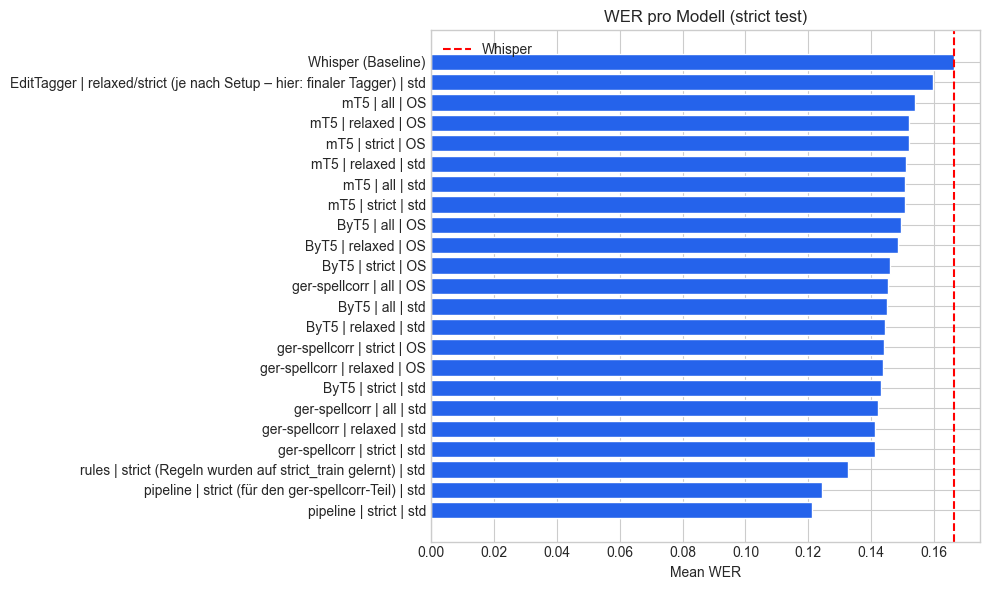

In [71]:

plot_df = wer_summary.sort_values("mean_wer")
plt.figure(figsize=(10, 6))
plt.barh(plot_df["label"], plot_df["mean_wer"], color="#2563eb")
plt.axvline(
    wer_summary.loc[wer_summary["pred_key"] == BASELINE_KEY, "mean_wer"].values[0],
    color="red",
    linestyle="--",
    label="Whisper",
)
plt.xlabel("Mean WER")
plt.title("WER pro Modell (strict test)")
plt.legend()
plt.tight_layout()
plt.show()



### Beispiele: Wo gewinnen oder verlieren die besten Modelle?


In [72]:
def _build_wer_example_subset(pred_key: str, indices, delta: pd.Series) -> pd.DataFrame:
    meta = systems_df.loc[pred_key]
    baseline_meta = systems_df.loc[BASELINE_KEY]
    index_list = list(indices)
    subset = agg_df.loc[index_list, [
        REF_COLUMN,
        baseline_meta["output_col"],
        meta["output_col"],
        baseline_meta["wer_column"],
        meta["wer_column"],
    ]].copy()
    subset.rename(
        columns={
            REF_COLUMN: "reference",
            baseline_meta["output_col"]: "whisper",
            meta["output_col"]: meta["label"],
            baseline_meta["wer_column"]: "WER_whisper",
            meta["wer_column"]: f"WER_{pred_key}",
        },
        inplace=True,
    )
    subset["delta_vs_whisper"] = delta.loc[index_list]
    return subset


def extract_wer_examples(pred_key: str, best: bool = True, n: int = 5) -> pd.DataFrame:
    if pred_key == BASELINE_KEY:
        raise ValueError("Baseline liefert keine Verbesserungsbeispiele")
    model_wer = get_wer_series(pred_key)
    baseline_wer = get_wer_series(BASELINE_KEY)
    delta = baseline_wer - model_wer
    order = delta.sort_values(ascending=not best)
    indices = order.head(n).index
    return _build_wer_example_subset(pred_key, indices, delta)


def extract_small_wer_gains(pred_key: str, n: int = 20, min_gain: float = 0.0) -> pd.DataFrame:
    if pred_key == BASELINE_KEY:
        raise ValueError("Baseline liefert keine Verbesserungsbeispiele")
    delta = get_wer_series(BASELINE_KEY) - get_wer_series(pred_key)
    positive_delta = delta[delta > min_gain]
    order = positive_delta if not positive_delta.empty else delta
    order = order.sort_values(ascending=True)
    indices = order.head(n).index
    return _build_wer_example_subset(pred_key, indices, delta)


best_models = (
    wer_summary[wer_summary["pred_key"] != BASELINE_KEY]
    .nsmallest(10, "mean_wer")
    .reset_index(drop=True)
)

for _, row in best_models.iterrows():
    print(f"Top improvements for {row['pred_key']} {row['label']}:")
    display(extract_wer_examples(row["pred_key"], best=True))
    print(f"Largest regressions for {row['pred_key']} {row['label']}:")
    display(extract_wer_examples(row["pred_key"], best=False))

Top improvements for rules-tx pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_rules-tx,delta_vs_whisper
13354,unogeneralsekretär ban kimoon sprach von kriegsverbrechen,der unogeneralsekretär ban kimoon hat von kriegsverbrechen gesprochen,unogeneralsekretär ban kimoon sprach von kriegsverbrechen,0.5,0.0,0.5
10006,und das sei doch etwas gutes,und da sehe ich doch etwas gutes,und das sei doch etwas gutes,0.5,0.0,0.5
12575,murray hat gute erinnerungen an federer,der murray hat eine gute erinnerung an federer,murray hat gute erinnerungen an federer,0.5,0.0,0.5
12034,es muss eine heizung eingebaut werden,es müsse heizig eingebaut werden,es muss eine heizung eingebaut werden,0.5,0.0,0.5
5974,denn damals wurden tatsächlich neuheiten enthüllt,weil damals sind tatsächlich neuheiten enthüllt worden,denn damals wurden tatsächlich neuheiten enthüllt,0.5,0.0,0.5


Largest regressions for rules-tx pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_rules-tx,delta_vs_whisper
924,zu den kosten,zu den kösten,zu den kosten kam es zu den kosten,0.333333,1.666667,-1.333333
18378,zu den kosten,zu den küsten,zu den küsten rückte er,0.333333,1.000000,-0.666667
3295,zu den kosten,zu den küsten,zu den küsten rückte er,0.333333,1.000000,-0.666667
9398,die rockwellsituation verfolgen wir permanent,die rückquellensituation verfolgen wir permanent,die rückfälle in der situation verfolgen wir permanent,0.200000,0.800000,-0.600000
21786,geschätzter präsident liebe anwesenden,schätzter präsident liebe owasendi,schätzt der präsident lieber owasendi,0.500000,1.000000,-0.500000


Top improvements for tx-rules-tx pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_tx-rules-tx,delta_vs_whisper
19817,ich danke dem stadtrat,ich danke im ständerot,ich danke dem stadtrat,0.5,0.0,0.5
4652,ist das auch eines ihrer motive,ist das auch eines von ihren motiven,ist das auch eines ihrer motive,0.5,0.0,0.5
20001,ist das auch eines ihrer motive,ist das auch eines von ihren motiven,ist das auch eines ihrer motive,0.5,0.0,0.5
7212,die polizei nahm in dem fall bislang 15 verdächtige fest,die polizei hat in diesem fall bis jetzt 15 verdächtige festgenommen,die polizei nahm in dem fall bislang 15 verdächtige fest,0.5,0.0,0.5
4845,ist das auch eines ihrer motive,ist das auch eines von ihren motiven,ist das auch eines ihrer motive,0.5,0.0,0.5


Largest regressions for tx-rules-tx pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_tx-rules-tx,delta_vs_whisper
3295,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
18378,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
12542,turnfest bewilligt,das turnfest bewilligt,das turnfest bewilligte ihn,0.500000,1.500000,-1.000000
11786,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
13710,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000


Top improvements for tx-rules pipeline | strict (für den ger-spellcorr-Teil) | std:


,reference,whisper,pipeline | strict (für den ger-spellcorr-Teil) | std,WER_whisper,WER_tx-rules,delta_vs_whisper
2006,diese bereitschaft war bislang eher klein,die bereitschaft war bis jetzt eher klein,diese bereitschaft war bislang eher klein,0.5,0.0,0.5
285,hier gehts zu den damaligen zeilen,hier geht es zu den damaligen zielen,hier gehts zu den damaligen zeilen,0.5,0.0,0.5
6054,antrag 3 wurde zurückgezogen,antrag 3 ist zurückgezogen worden,antrag 3 wurde zurückgezogen,0.5,0.0,0.5
15762,dennoch spielte er immer noch grossartig,trotzdem hat er immer noch grossartig gespielt,dennoch spielte er immer noch grossartig,0.5,0.0,0.5
13488,die polizei nahm in dem fall bislang 15 verdächtige fest,die polizei hat in diesem fall bis jetzt 15 verdächtige festgenommen,die polizei nahm in dem fall bislang 15 verdächtige fest,0.5,0.0,0.5


Largest regressions for tx-rules pipeline | strict (für den ger-spellcorr-Teil) | std:


,reference,whisper,pipeline | strict (für den ger-spellcorr-Teil) | std,WER_whisper,WER_tx-rules,delta_vs_whisper
3295,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
18378,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
13223,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
9126,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
8069,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000


Top improvements for rules rules | strict (Regeln wurden auf strict_train gelernt) | std:


,reference,whisper,rules | strict (Regeln wurden auf strict_train gelernt) | std,WER_whisper,WER_rules,delta_vs_whisper
11638,was bedeutete heute zeitgemäss,was hat heute zeitgemäss bedeutet,was bedeutete heute zeitgemäss,0.5,0.0,0.5
12819,diese fr 1500000 lösen also eigentlich fr 6000000,diese 15000 franken lösen also eigentlich 60000 franken,diese fr 1500000 lösen also eigentlich fr 6000000,0.5,0.0,0.5
11943,ich habe einige fragen,ich habe ein paar fragen,ich habe einige fragen,0.5,0.0,0.5
1894,das dürfte vor allem für betroffene interessant sein,das darf dir vor allem für die betroffenen interessant sein,das dürfte vor allem für betroffene interessant sein,0.5,0.0,0.5
16129,danke für diese frage,danke für die fragen,danke für diese frage,0.5,0.0,0.5


Largest regressions for rules rules | strict (Regeln wurden auf strict_train gelernt) | std:


,reference,whisper,rules | strict (Regeln wurden auf strict_train gelernt) | std,WER_whisper,WER_rules,delta_vs_whisper
19132,ich mache zwei bemerkungen,ich mache zwei bemerkungen,ich mache 2 bemerkungen,0.0,0.25,-0.25
16078,es waren nur vier oder fünf grundeigentümer beteiligt,es waren nur vier oder fünf grundeigentümer beteiligt,es waren nur 4 oder 5 grundeigentümer beteiligt,0.0,0.25,-0.25
20783,die vier typen unterscheiden sich in zwei dimensionen,die vier typen unterscheiden sich in zwei dimensionen,die 4 typen unterscheiden sich in 2 dimensionen,0.0,0.25,-0.25
15540,ich mache zwei bemerkungen,ich mache zwei bemerkungen,ich mache 2 bemerkungen,0.0,0.25,-0.25
13435,ich mache zwei bemerkungen,ich mache zwei bemerkungen,ich mache 2 bemerkungen,0.0,0.25,-0.25


Top improvements for ger-spellcorr-base_strict_conf_marked ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict_conf_marked,delta_vs_whisper
1414,es sei zwar keine generelle empfehlung,es sind zwar keine generellen empfehlungen,es sei zwar keine generelle empfehlung,0.5,0.0,0.5
4061,es sei zwar keine generelle empfehlung,es sind zwar keine generellen empfehlungen,es sei zwar keine generelle empfehlung,0.5,0.0,0.5
4845,ist das auch eines ihrer motive,ist das auch eines von ihren motiven,ist das auch eines ihrer motive,0.5,0.0,0.5
21369,der text wurde entschlackt,der text ist entschlackt worden,der text wurde entschlackt,0.5,0.0,0.5
12819,diese fr 1500000 lösen also eigentlich fr 6000000,diese 15000 franken lösen also eigentlich 60000 franken,diese fr 1500000 lösen also eigentlich fr 6000000,0.5,0.0,0.5


Largest regressions for ger-spellcorr-base_strict_conf_marked ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict_conf_marked,delta_vs_whisper
13379,start und beschleunigung waren gar bescheiden,start und beschleunigung waren ganz unterschiedlich,die steuer und die beschleunigung seien ganz unterschiedlich gewesen,0.333333,1.166667,-0.833333
2611,kupplung und bremsen bleiben unauffällig,die kopplung bremsen bleiben unauffällig,die kopplung in die bremse bleibe unauffällig,0.400000,1.200000,-0.800000
16246,allerdings wurden die sicherheitsvorkehrungen verstärkt,allerdings wurde die sicherheitsvorkehrungen verstärkt,allerdings sei die sicherheit vor kehrungen verstärkt worden,0.200000,1.000000,-0.800000
2081,allerdings wurden die sicherheitsvorkehrungen verstärkt,allerdings wurden die sicherheitsvorkriegen verstärkt,allerdings sei die sicherheit vor kriegen verstärkt worden,0.200000,1.000000,-0.800000
5417,was bedeutete heute zeitgemäss,was bedeutet heute zeitgemäss,was bedeutet heute die zeit gemäss,0.250000,1.000000,-0.750000


Top improvements for ger-spellcorr-base_strict ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict,delta_vs_whisper
936,es wurde intensiv diskutiert,es ist intensiv diskutiert worden,es wurde intensiv diskutiert,0.5,0.0,0.5
19713,der text wurde entschlackt,der text ist entschlackt worden,der text wurde entschlackt,0.5,0.0,0.5
18185,wir bleiben am ball,mir blieben am ball,wir bleiben am ball,0.5,0.0,0.5
20224,der text wurde entschlackt,der text ist entschlackt worden,der text wurde entschlackt,0.5,0.0,0.5
13835,hier liegen nun verschiedene vorschläge vor,da legen jetzt verschiedene vorschläge vor,hier liegen nun verschiedene vorschläge vor,0.5,0.0,0.5


Largest regressions for ger-spellcorr-base_strict ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict,delta_vs_whisper
18378,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
3295,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
1774,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
11786,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
13710,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000


Top improvements for ger-spellcorr-base_relaxed ger-spellcorr | relaxed | std:


,reference,whisper,ger-spellcorr | relaxed | std,WER_whisper,WER_ger-spellcorr-base_relaxed,delta_vs_whisper
11422,lugano liegt erstmals seit november über dem strich,lugano liegt das erste mal seit november über diesem strich,lugano liegt erstmals seit november über dem strich,0.5,0.0,0.5
9623,antrag 3 wurde zurückgezogen,antrag 3 ist zurückgezogen worden,antrag 3 wurde zurückgezogen,0.5,0.0,0.5
3905,diese fr 1500000 lösen also eigentlich fr 6000000,diese 15000 franken lösen also eigentlich 60000 franken,diese fr 1500000 lösen also eigentlich fr 6000000,0.5,0.0,0.5
16946,das passt natürlich gut zum 100jahrejubiläum,das passt natürlich gut zum 100 jahre jubiläum,das passt natürlich gut zum 100jahrejubiläum,0.5,0.0,0.5
11504,es zeigten sich aber grosse schwankungen,es haben sich aber grosse schmankungen gezeigt,es zeigten sich aber grosse schwankungen,0.5,0.0,0.5


Largest regressions for ger-spellcorr-base_relaxed ger-spellcorr | relaxed | std:


,reference,whisper,ger-spellcorr | relaxed | std,WER_whisper,WER_ger-spellcorr-base_relaxed,delta_vs_whisper
11248,zu den kosten,zu den kosten,zu den kosten kam es zu den kosten,0.000000,1.666667,-1.666667
13931,zu den kosten,zu den kosten,zu den kosten kam es zu den kosten,0.000000,1.666667,-1.666667
924,zu den kosten,zu den kösten,zu den kosten kam es zu den kosten,0.333333,1.666667,-1.333333
3295,zu den kosten,zu den küsten,zu den kosten kam es zu den kosten,0.333333,1.666667,-1.333333
18378,zu den kosten,zu den küsten,zu den kosten kam es zu den kosten,0.333333,1.666667,-1.333333


Top improvements for ger-spellcorr-base_strict_twice ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict_twice,delta_vs_whisper
15770,das unwetter dauerte etwa fünf stunden,das unwetter hat etwa 5 stunden gedauert,das unwetter dauerte etwa fünf stunden,0.5,0.0,0.5
20854,wobei letzteres infrage gestellt werden muss,wobei letztens in frage gestellt werden muss,wobei letzteres infrage gestellt werden muss,0.5,0.0,0.5
18755,denn damals wurden tatsächlich neuheiten enthüllt,weil damals sind tatsächlich neuheiten enthüllt worden,denn damals wurden tatsächlich neuheiten enthüllt,0.5,0.0,0.5
19363,woher bekommt der körper vitamin d,wo er bekommt den körper vitamin d,woher bekommt der körper vitamin d,0.5,0.0,0.5
17778,und gitarre spielen kann er auch,und gitarrespieler kann auch,und gitarre spielen kann er auch,0.5,0.0,0.5


Largest regressions for ger-spellcorr-base_strict_twice ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict_twice,delta_vs_whisper
3295,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
18378,zu den kosten,zu den küsten,zu den kosten rückte er zu den kosten,0.333333,1.666667,-1.333333
12542,turnfest bewilligt,das turnfest bewilligt,das turnfest bewilligte ihn,0.500000,1.500000,-1.000000
1774,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000
11786,last but not least,last but not least,last not just last,0.000000,0.750000,-0.750000


Top improvements for ger-spellcorr-base_all ger-spellcorr | all | std:


,reference,whisper,ger-spellcorr | all | std,WER_whisper,WER_ger-spellcorr-base_all,delta_vs_whisper
5130,bitte tragen sie ihre verfügbarkeit ein,bitte tragt ihr eure verfügbarkeit ein,bitte tragen sie ihre verfügbarkeit ein,0.5,0.0,0.5
9762,der rhythmus eines satzes sei entscheidend,der rhythmus von einem satz sei entscheidend,der rhythmus eines satzes sei entscheidend,0.5,0.0,0.5
3976,die beiden wurden schwer verletzt ins spital eingeliefert,die beiden sind schwer verletzte in spital eingeliefert worden,die beiden wurden schwer verletzt ins spital eingeliefert,0.5,0.0,0.5
18151,meissner fand sogar einen originalen motor,der meissner hat sogar einen originalen motor gefunden,meissner fand sogar einen originalen motor,0.5,0.0,0.5
16270,dieser einschätzung folgten auch die geschworenen,deren einschätzung sind auch die geschworenen gefolgt,dieser einschätzung folgten auch die geschworenen,0.5,0.0,0.5


Largest regressions for ger-spellcorr-base_all ger-spellcorr | all | std:


,reference,whisper,ger-spellcorr | all | std,WER_whisper,WER_ger-spellcorr-base_all,delta_vs_whisper
3295,zu den kosten,zu den küsten,zu den küsten kam es zu den küsten,0.333333,2.000000,-1.666667
18378,zu den kosten,zu den küsten,zu den küsten kam es zu den küsten,0.333333,2.000000,-1.666667
13931,zu den kosten,zu den kosten,zu den kosten kam es zu den kosten,0.000000,1.666667,-1.666667
11248,zu den kosten,zu den kosten,zu den kosten kam es zu den kosten,0.000000,1.666667,-1.666667
924,zu den kosten,zu den kösten,zu den kosten kam es zu den kosten,0.333333,1.666667,-1.333333


Top improvements for byt5_strict ByT5 | strict | std:


,reference,whisper,ByT5 | strict | std,WER_whisper,WER_byt5_strict,delta_vs_whisper
9762,der rhythmus eines satzes sei entscheidend,der rhythmus von einem satz sei entscheidend,der rhythmus eines satzes sei entscheidend,0.5,0.0,0.5
13492,sonst passiert keine förderung,sonst passiert kein förderig,sonst passiert keine förderung,0.5,0.0,0.5
936,es wurde intensiv diskutiert,es ist intensiv diskutiert worden,es wurde intensiv diskutiert,0.5,0.0,0.5
9623,antrag 3 wurde zurückgezogen,antrag 3 ist zurückgezogen worden,antrag 3 wurde zurückgezogen,0.5,0.0,0.5
20224,der text wurde entschlackt,der text ist entschlackt worden,der text wurde entschlackt,0.5,0.0,0.5


Largest regressions for byt5_strict ByT5 | strict | std:


,reference,whisper,ByT5 | strict | std,WER_whisper,WER_byt5_strict,delta_vs_whisper
13477,das wäre wosakonform,das wäre wusakonform,das wäre wohl aus der konform,0.333333,1.333333,-1.000000
9648,das wäre wosakonform,das war wosakonform,das war wohl konform,0.333333,1.000000,-0.666667
14766,ost wird genehmigt,ost wird genammigt,auch die ost wird genammigt,0.333333,1.000000,-0.666667
3218,das wäre wosakonform,das wäre bosakonform,das wäre eine basler konform,0.333333,1.000000,-0.666667
11976,das wäre wosakonform,das war wosakonform,das war wohl konform,0.333333,1.000000,-0.666667


In [73]:
low_gain_targets = [
    "rules",
    "ger-spellcorr-base_strict",
    "ger-spellcorr-base_strict_conf_marked",
    "tagger",
]

for key in low_gain_targets:
    if key not in systems_df.index:
        print(f"{key}: Kein Systemeintrag vorhanden.")
        continue
    label = systems_df.loc[key, "label"]
    print(f"Kleinste positiven WER-Gewinne für {key} ({label}):")
    display(extract_small_wer_gains(key, n=20))

Kleinste positiven WER-Gewinne für rules (rules | strict (Regeln wurden auf strict_train gelernt) | std):


,reference,whisper,rules | strict (Regeln wurden auf strict_train gelernt) | std,WER_whisper,WER_rules,delta_vs_whisper
4892,es würde aufgezeigt was für angebote altersgereicht für die kinder vorhanden sind,es würde aufzeigt werden was für altersgerechte angebote für kinder vorhanden sind,es würde aufgezeigt werden was für altersgerechte angebote für kinder vorhanden sind,0.416667,0.333333,0.083333
15469,jetzt haben wir das projekt torfeld und das geht in die pipeline,jetzt fällt das projektor nach hause und das geht in die pipeline,jetzt fällt das projektor nachhause und das geht in die pipeline,0.416667,0.333333,0.083333
17942,diese verdienen dass man sie auch im hohen lebensalter noch gut unterstützt,es ist schon verdient dass man sich auch im hohen lebensalter noch gut unterstützt,es ist schon verdient dass man sie auch im hohen lebensalter noch gut unterstützt,0.416667,0.333333,0.083333
14440,das sind für den gemeinderat die strategischen positionen die wir getätigt haben,für den gemeinderat sind das die strategischen positionen die wir tätig haben,für den gemeinderat sind das die strategischen positionen die wir getätigt haben,0.416667,0.333333,0.083333
14418,der gemeinderat konnte der finanzkommission nachvollziehbar die hintergründe der getätigten landeerwerbsfälle erläutern,gemeinderat hat der finanzkommission nachvollziehbar die hintergründe der tätigen landerwerksfälle erläutern können,gemeinderat hat der finanzkommission nachvollziehbar die hintergründe der getätigten landerwerksfälle erläutern können,0.416667,0.333333,0.083333
16524,die spfraktion schlägt mir ihr eine ausgezeichnete kandidatin für die fgpk vor,die spfraktion schlägt mir einen ausgezeichneten kandidaten für die fgbk vor,die spfraktion schlägt mir einen ausgezeichneten kandidaten für die fgpk vor,0.416667,0.333333,0.083333
9800,wir sind der meinung dass wir nicht auf der bremse stehen sollten,wir sind meinig dass man nicht auf der bremse stoßt,wir sind meinung dass man nicht auf der bremse stosst,0.416667,0.333333,0.083333
12026,ich möchte es nciht verantworten müssen wenn sich dort ein unfall ereignet,ich wollte es nicht verantworten müssen was sich durch einen unfall ereignet,ich wollte es nicht verantworten müssen was sich nur ein unfall ereignet,0.416667,0.333333,0.083333
18701,bei der verfügung einer beistandschaft ist eine zügige aber sorgfältige fallbearbeitung gefragt,für die verfügung von einer biestandschaft ist eine zügige aber sorgfältige fallbearbeitung gefordert,der verfügung von einer biestandschaft ist eine zügige aber sorgfältige fallbearbeitung gefordert,0.416667,0.333333,0.083333
5249,die fraktion der fdp lehnt darum die überweisung dieses postulats einstimmig ab,die fraktion der fdp lehnt darum die überweisung für den postulat der einstimmung ab,die fraktion der fdp lehnt darum die überweisung für den postulat der einstimmig ab,0.416667,0.333333,0.083333


Kleinste positiven WER-Gewinne für ger-spellcorr-base_strict (ger-spellcorr | strict | std):


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict,delta_vs_whisper
7541,allerdings basiert die aktuelle reihe der spanier auf dem vorgänger des a4,allerdings basiert der jagdtür die reihe von der spanier auf dem vorgänger vom a4,allerdings basiert der jagd für die reihe der spanier auf dem vorgänger des a4,0.416667,0.333333,0.083333
11650,das ist ein sogenanntes zug um zug geschäft welches gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft das gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft welches gewährleistet werden muss,0.416667,0.333333,0.083333
21837,das ist ein sogenanntes zug um zug geschäft welches gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft weil es gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft welches gewährleistet werden muss,0.416667,0.333333,0.083333
19953,bedenken sie wir sprechen über den betrieb mit mehr als 20 kundenparkplätze,bedenkt bitte wir reden über einen betrieb mit mehr als 20 kundenparkplätzen,bedenken bitte wir reden über einen betrieb mit mehr als 20 kundenparkplätzen,0.416667,0.333333,0.083333
20466,im moment spielen die frauen des fc aarau in der nationalliga b,im moment spielt uns die freude vom fc aarau in der nationalliga bei,im moment spielt uns die freude des fc aarau in der nationalliga bei,0.416667,0.333333,0.083333
7161,rund 200 ausgefüllte fragebogen übergebe ich jetzt gerne dem gemeinderat als lektüre,um die 200 ausgefüllten fragebögen übergebe ich jetzt gern dem gemeinderat als lektüre,um die 200 ausgefüllten fragebögen übergebe ich jetzt gerne dem gemeinderat als lektüre,0.416667,0.333333,0.083333
19034,das ist ein sogenanntes zug um zug geschäft welches gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft das gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft welches gewährleistet werden muss,0.416667,0.333333,0.083333
18701,bei der verfügung einer beistandschaft ist eine zügige aber sorgfältige fallbearbeitung gefragt,für die verfügung von einer biestandschaft ist eine zügige aber sorgfältige fallbearbeitung gefordert,für die verfügung einer bestandschaft ist eine zügige aber sorgfältige fallbearbeitung gefordert,0.416667,0.333333,0.083333
13096,bedenken sie wir sprechen über den betrieb mit mehr als 20 kundenparkplätze,denken sie daran wir reden über einen betrieb mit mehr als 20 kundenparkplätzen,denken sie daran wir sprechen über einen betrieb mit mehr als 20 kundenparkplätzen,0.416667,0.333333,0.083333
8627,wenn wir das tägi auslagern sinken der personalaufwand und der sachaufwand steigt,wenn wir das tagi auslagern sinkt der personalaufwand und das sachaufwandstück,wenn wir das tägi auslagern sinkt der personalaufwand und das sachaufwandstück,0.416667,0.333333,0.083333


Kleinste positiven WER-Gewinne für ger-spellcorr-base_strict_conf_marked (ger-spellcorr | strict | std):


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict_conf_marked,delta_vs_whisper
19034,das ist ein sogenanntes zug um zug geschäft welches gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft das gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft welches gewährleistet werden muss,0.416667,0.333333,0.083333
20466,im moment spielen die frauen des fc aarau in der nationalliga b,im moment spielt uns die freude vom fc aarau in der nationalliga bei,im moment spielt uns die freude des fc aarau in der nationalliga bei,0.416667,0.333333,0.083333
7161,rund 200 ausgefüllte fragebogen übergebe ich jetzt gerne dem gemeinderat als lektüre,um die 200 ausgefüllten fragebögen übergebe ich jetzt gern dem gemeinderat als lektüre,um die 200 ausgefüllten fragebögen übergebe ich jetzt gerne dem gemeinderat als lektüre,0.416667,0.333333,0.083333
15900,deshalb begrüsst die mehrheit der sp fraktion den kauf der liegenschaft walthersburg,deshalb begrüsst behrheit von der spfraktion den kauf der liegenschaft waltersburg,deshalb begrüsst die behörde von der spfraktion den kauf der liegenschaft walthersburg,0.416667,0.333333,0.083333
3616,bedenken sie wir sprechen über den betrieb mit mehr als 20 kundenparkplätze,wir danken sie wir reden über den betrieb mit mehr als 20 kunden parkplatz,wir danken sie wir reden über den betrieb mit mehr als 20 kundenparkplätzen,0.416667,0.333333,0.083333
21837,das ist ein sogenanntes zug um zug geschäft welches gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft weil es gewährleistet werden muss,das ist ein sogenanntes zugumzuggeschäft welches gewährleistet werden muss,0.416667,0.333333,0.083333
2724,weiter haben wir den antrag des gemeinderats sowie die anträge der finanzkommission,weiter haben wir anträge vom gemeinderat sowie die anträge von der finanzkommission,weiter haben wir anträge vom gemeinderat sowie die anträge der finanzkommission,0.416667,0.333333,0.083333
4501,ich bitte laszlo etesi sich für die inpflichtnahme nach vorne zu begeben,ich bitte den laszlo ettensee sich für die empflichtnahme nach vorn zu begehen,ich bitte lszlo ettelsee sich für die empflichtnahme nach vorn zu begeben,0.416667,0.333333,0.083333
14164,genauso verhält es sich bei der aussage dass die beteiligung strategisch sei,genauso verhaltet sich bei der aussage dass die beteiligung der strategier feige,genauso verhält sich bei der aussage dass die beteiligung der strategie fehle,0.416667,0.333333,0.083333
7541,allerdings basiert die aktuelle reihe der spanier auf dem vorgänger des a4,allerdings basiert der jagdtür die reihe von der spanier auf dem vorgänger vom a4,allerdings basiert der jagd die reihe der spanier auf dem vorgänger der a4,0.416667,0.333333,0.083333


Kleinste positiven WER-Gewinne für tagger (EditTagger | relaxed/strict (je nach Setup – hier: finaler Tagger) | std):


,reference,whisper,EditTagger | relaxed/strict (je nach Setup – hier: finaler Tagger) | std,WER_whisper,WER_tagger,delta_vs_whisper
10862,die transformation hat mit dem vorherrschen des angebots und dernachfrage zu tun,die transformation hat mit dem vorherschen vom angebot und der nachfrage zu tun,die transformation hat mit dem vorherschen des angebot und der nachfrage zu tun,0.416667,0.333333,0.083333
4501,ich bitte laszlo etesi sich für die inpflichtnahme nach vorne zu begeben,ich bitte den laszlo ettensee sich für die empflichtnahme nach vorn zu begehen,ich bitte laszlo ettensee sich für die en nach vorn zu begehen,0.416667,0.333333,0.083333
17761,deshalb begrüsst die mehrheit der sp fraktion den kauf der liegenschaft walthersburg,deshalb hat die mehrheit der spfraktion den kauf der liegenschaft waltersburg begrüsst,deshalb beg die mehrheit der spfraktion den kauf der liegenschaft waltersburg,0.416667,0.333333,0.083333
18896,von den rahmenbedingungen her wurde alles zur lösung dieses komplexen projektes vorgenommen,von den rahmenbedingungen her ist alles für die lösung dieses komplexen projekts vorgenommen worden,von den rahmenbedingungen her wurde alles für die lösung des komplexen projekts vorgenommen,0.416667,0.333333,0.083333
10541,für die grüne fraktion steht deshalb fest dass tagesschulen ein bedürfnis sind,für die grünenfraktion steht drum fest dass tagesschule das bedürfnis sind,für die grünenfraktion steht deshalb fest dass tagesschule das bedürfnis sind,0.416667,0.333333,0.083333
14418,der gemeinderat konnte der finanzkommission nachvollziehbar die hintergründe der getätigten landeerwerbsfälle erläutern,gemeinderat hat der finanzkommission nachvollziehbar die hintergründe der tätigen landerwerksfälle erläutern können,gemeinderat konnte der finanzkommission nachvollziehbar die hintergründe der tätigen landerwerksfälle erläutern können,0.416667,0.333333,0.083333
11257,deshalb wollten wir den fdpantrag unterstützen nochmals über den preis zu verhandeln,deswegen wollten wir den fdpantrag unterstützen um nochmal über den preis zu verhandeln,deshalb wollten wir den fdpantrag unterstützen um nochmal über den preis zu verhandeln,0.250000,0.166667,0.083333
12389,die kommission sprach sich dafür aus dies in den planungsbericht zu integrieren,die kommission hat sich dafür aussprochen das in den planungsbericht zu integrieren,die kommission sprach sich dafür aussprochen das in den planungsbericht zu integrieren,0.250000,0.166667,0.083333
10735,von den rahmenbedingungen her wurde alles zur lösung dieses komplexen projektes vorgenommen,von den rahmenbedingungen her ist alles zur lösung dieses komplexen projekts vorgenommen worden,von den rahmenbedingungen her wurde alles zur lösung des komplexen projekts vorgenommen,0.250000,0.166667,0.083333
1728,deshalb ist ein vergleich mit der privatwirtschaft unserer meinung nach nicht angebracht,darum ist ein vergleich mit der privatwirtschaft dieser meinung noch nicht angebracht,deshalb ist ein vergleich mit der privatwirtschaft dieser meinung noch nicht angebracht,0.250000,0.166667,0.083333


## Embedding Similarity Analyse
Wir verwenden das gleiche Sentence-Transformer-Modell wie in den Skripten, um Embeddings für `sentence_norm`, `transcript_norm` (Whisper) und die ausgewählten Modelle (`ger-spellcorr-base_strict_out`, `rules`, `rules-tx`) zu berechnen und anschließend mit der Referenz zu vergleichen.


In [74]:
EMB_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
EMB_BATCH_SIZE = 128
EMBEDDING_TARGETS = [
    "whisper",
    "ger-spellcorr-base_strict",
    "rules",
    "rules-tx",
]

available_targets = [key for key in EMBEDDING_TARGETS if key in systems_df.index]
if BASELINE_KEY not in available_targets:
    available_targets.insert(0, BASELINE_KEY)

print("Berechne Embeddings für:", available_targets)

print("Lade SentenceTransformer:", EMB_MODEL_NAME)
emb_model = SentenceTransformer(EMB_MODEL_NAME)


def encode_texts(texts: list[str]) -> np.ndarray:
    return emb_model.encode(
        texts,
        batch_size=EMB_BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )


print("-> sentence_norm (Referenz)")
ref_texts = agg_df[REF_COLUMN].fillna("").astype(str).tolist()
ref_embs = encode_texts(ref_texts)

for key in available_targets:
    meta = systems_df.loc[key]
    column = meta["output_col"]
    print(f"-> {meta['label']} ({column})")
    texts = agg_df[column].fillna("").astype(str).tolist()
    hyp_embs = encode_texts(texts)
    sims = (ref_embs * hyp_embs).sum(axis=1)
    sims = np.clip((sims + 1.0) / 2.0, 0.0, 1.0)
    agg_df[f"emb_sim_{key}"] = sims
    print(f"Embedding Similarity für {meta['label']} → Spalte emb_sim_{key}")


Berechne Embeddings für: ['whisper', 'ger-spellcorr-base_strict', 'rules', 'rules-tx']
Lade SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
-> sentence_norm (Referenz)


Batches:   0%|          | 0/171 [00:00<?, ?it/s]

-> Whisper (Baseline) (transcript_norm)


Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Embedding Similarity für Whisper (Baseline) → Spalte emb_sim_whisper
-> ger-spellcorr | strict | std (ger-spellcorr-base_strict_out)


Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Embedding Similarity für ger-spellcorr | strict | std → Spalte emb_sim_ger-spellcorr-base_strict
-> rules | strict (Regeln wurden auf strict_train gelernt) | std (rules)


Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Embedding Similarity für rules | strict (Regeln wurden auf strict_train gelernt) | std → Spalte emb_sim_rules
-> pipeline | strict | std (rules-tx)


Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Embedding Similarity für pipeline | strict | std → Spalte emb_sim_rules-tx


In [75]:

emb_cols = [f"emb_sim_{key}" for key in available_targets if f"emb_sim_{key}" in agg_df]
emb_summary = (
    agg_df[emb_cols]
    .agg(["mean", "median", "std"])
    .T
    .rename_axis("metric")
    .reset_index()
)
emb_summary


,metric,mean,median,std
0,emb_sim_whisper,0.975388,0.995277,0.045675
1,emb_sim_ger-spellcorr-base_strict,0.978515,0.997650,0.043557
2,emb_sim_rules,0.978695,0.997660,0.043324
3,emb_sim_rules-tx,0.980346,0.999664,0.042643


In [79]:
# Wir gehen davon aus:
# - get_wer_series(...) ist definiert
# - BASELINE_KEY, agg_df, systems_df, emb_sim-Spalten existieren

def find_wer_sim_examples(
    pred_key: str,
    n_each: int = 5,
    wer_big_thresh: float = 0.30,    # z.B. >= 0.30 absolute WER-Verbesserung
    wer_small_max: float = 0.10,     # z.B. <= 0.05 absolute WER-Verbesserung
    sim_small_max: float = 0.05,     # "kaum" Similarity-Veränderung
    sim_big_thresh: float = 0.15     # "große" Similarity-Verbesserung
) -> dict:
    """
    Liefert Beispiel-DataFrames für ein System pred_key:
    - big_wer_small_sim: große WER-Verbesserung, kleine Similarity-Verbesserung
    - small_wer_big_sim: kleine WER-Verbesserung, große Similarity-Verbesserung
    - big_sim: allgemein große Similarity-Verbesserung
    """

    if pred_key == BASELINE_KEY:
        raise ValueError("pred_key sollte != BASELINE_KEY sein.")

    # --- WER-Serien holen ---
    wer_baseline = get_wer_series(BASELINE_KEY)
    wer_system = get_wer_series(pred_key)

    # --- Similarities holen ---
    sim_baseline_col = f"emb_sim_{BASELINE_KEY}"
    sim_system_col = f"emb_sim_{pred_key}"
    if sim_baseline_col not in agg_df or sim_system_col not in agg_df:
        raise KeyError(
            f"Embedding-Spalten {sim_baseline_col} und/oder {sim_system_col} fehlen. "
            "Bitte zuerst den Embedding-Code laufen lassen."
        )

    sim_baseline = agg_df[sim_baseline_col]
    sim_system = agg_df[sim_system_col]

    # --- Delta-Berechnungen ---
    delta_wer = wer_baseline - wer_system       # > 0 = WER verbessert
    delta_sim = sim_system - sim_baseline       # > 0 = Similarity verbessert

    # Kleiner Hilfs-DataFrame mit Kontext
    # Falls du eine explizite ID-Spalte hast (z.B. "utt_id"), kannst du die hier ergänzen.
    df = pd.DataFrame(
        {
            "row_id": agg_df.index,
            "ref": agg_df[REF_COLUMN].astype(str),
            "hyp_baseline": agg_df[systems_df.loc[BASELINE_KEY, "output_col"]].astype(str),
            "hyp_system": agg_df[systems_df.loc[pred_key, "output_col"]].astype(str),
            "wer_baseline": wer_baseline,
            "wer_system": wer_system,
            "delta_wer": delta_wer,
            "sim_baseline": sim_baseline,
            "sim_system": sim_system,
            "delta_sim": delta_sim,
        }
    )

    # 1) Große WER-Verbesserung, aber kaum Similarity-Verbesserung
    mask_big_wer_small_sim = (df["delta_wer"] >= wer_big_thresh) & (df["delta_sim"].abs() <= sim_small_max)
    examples_big_wer_small_sim = (
        df[mask_big_wer_small_sim]
        .sort_values("delta_wer", ascending=False)
        .head(n_each)
    )

    # 2) Kleine WER-Verbesserung, aber große Similarity-Verbesserung
    mask_small_wer_big_sim = (df["delta_wer"].between(0, wer_small_max)) & (df["delta_sim"] >= sim_big_thresh)
    examples_small_wer_big_sim = (
        df[mask_small_wer_big_sim]
        .sort_values("delta_sim", ascending=False)
        .head(n_each)
    )

    # 3) Allgemein große Similarity-Verbesserung (egal wie WER sich verhält)
    mask_big_sim = df["delta_sim"] >= sim_big_thresh
    examples_big_sim = (
        df[mask_big_sim]
        .sort_values("delta_sim", ascending=False)
        .head(n_each)
    )

    return {
        "big_wer_small_sim": examples_big_wer_small_sim,
        "small_wer_big_sim": examples_small_wer_big_sim,
        "big_sim": examples_big_sim,
    }

# Beispiel-Aufruf für ein bestimmtes System, z.B. "rules"
examples_rules = find_wer_sim_examples("rules-tx", n_each=10)

print("=== Große WER-Verbesserung, kaum Similarity-Verbesserung ===")
display(examples_rules["big_wer_small_sim"][[
    "row_id", "ref", "hyp_baseline", "hyp_system",
    "wer_baseline", "wer_system", "delta_wer",
    "sim_baseline", "sim_system", "delta_sim"
]])

print("=== Kleine WER-Verbesserung, große Similarity-Verbesserung ===")
display(examples_rules["small_wer_big_sim"][[
    "row_id", "ref", "hyp_baseline", "hyp_system",
    "wer_baseline", "wer_system", "delta_wer",
    "sim_baseline", "sim_system", "delta_sim"
]])

print("=== Beispiele mit großer Similarity-Verbesserung ===")
display(examples_rules["big_sim"][[
    "row_id", "ref", "hyp_baseline", "hyp_system",
    "wer_baseline", "wer_system", "delta_wer",
    "sim_baseline", "sim_system", "delta_sim"
]])


=== Große WER-Verbesserung, kaum Similarity-Verbesserung ===


,row_id,ref,hyp_baseline,hyp_system,wer_baseline,wer_system,delta_wer,sim_baseline,sim_system,delta_sim
16463,16463,den dritten platz belegte bei den meisterschaften norwegen,der dritte platz hat bei den meisterschaften norwegen beleitet,den dritten platz belegte bei den meisterschaften norwegen,0.5,0.0,0.5,0.985664,1.0,0.014336
15495,15495,der text wurde entschlackt,der text ist entschlackt worden,der text wurde entschlackt,0.5,0.0,0.5,0.978020,1.0,0.021980
20854,20854,wobei letzteres infrage gestellt werden muss,wobei letztens in frage gestellt werden muss,wobei letzteres infrage gestellt werden muss,0.5,0.0,0.5,0.994142,1.0,0.005858
20001,20001,ist das auch eines ihrer motive,ist das auch eines von ihren motiven,ist das auch eines ihrer motive,0.5,0.0,0.5,0.976383,1.0,0.023617
13488,13488,die polizei nahm in dem fall bislang 15 verdächtige fest,die polizei hat in diesem fall bis jetzt 15 verdächtige festgenommen,die polizei nahm in dem fall bislang 15 verdächtige fest,0.5,0.0,0.5,0.991389,1.0,0.008611
9060,9060,offenbar wurde ein verbrechen nicht ausgeschlossen,offenbar ist ein verbrecher nicht ausgeschlossen worden,offenbar wurde ein verbrechen nicht ausgeschlossen,0.5,0.0,0.5,0.975390,1.0,0.024610
7435,7435,den dritten platz belegte bei den meisterschaften norwegen,der dritte platz hat bei den meisterschaften norwegen beleitet,den dritten platz belegte bei den meisterschaften norwegen,0.5,0.0,0.5,0.985664,1.0,0.014336
14046,14046,die svp wird dem antrag des gemeinderats folgen,svp wird am antrag vom gemeinderat folgen,die svp wird dem antrag des gemeinderats folgen,0.5,0.0,0.5,0.983510,1.0,0.016490
3976,3976,die beiden wurden schwer verletzt ins spital eingeliefert,die beiden sind schwer verletzte in spital eingeliefert worden,die beiden wurden schwer verletzt ins spital eingeliefert,0.5,0.0,0.5,0.995520,1.0,0.004480
8996,8996,warum hätten wir das tun sollen,wieso hätten wir das sollen tun,warum hätten wir das tun sollen,0.5,0.0,0.5,0.981332,1.0,0.018668


=== Kleine WER-Verbesserung, große Similarity-Verbesserung ===


,row_id,ref,hyp_baseline,hyp_system,wer_baseline,wer_system,delta_wer,sim_baseline,sim_system,delta_sim
19006,19006,reich wäre er damit allerdings auch nicht geworden,riech werden damit allerdings auch nicht worte,reich werden damit allerdings auch nicht die worte,0.500000,0.500000,0.000000,0.593669,0.892815,0.299146
1632,1632,die kapazitäten der schule seien damit bei weitem noch nicht ausgeschöpft,die kapazität der schuhe ist noch bei weitem nicht ausgeschöpft,die kapazitäten der schulen sind noch bei weitem nicht ausgeschöpft,0.454545,0.363636,0.090909,0.694459,0.992304,0.297845
14766,14766,ost wird genehmigt,ost wird genammigt,ost wird genehmigen,0.333333,0.333333,0.000000,0.722425,0.993916,0.271491
14367,14367,da fliessen nicht nur steuergelder,da fliessen nicht nur stiergalder,da fliessen nicht nur die steuergelder,0.200000,0.200000,0.000000,0.725678,0.997049,0.271371
10899,10899,die einführung einer neuen steuer bereitet der fraktion glp nicht wirklich freude,die führung einer neuen stier verreitet der fraktion glp nicht wirklich freude,die führung einer neuen steuer verbreitet der fraktion glp nicht wirklich freude,0.250000,0.166667,0.083333,0.741684,0.992904,0.251219
18866,18866,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,darum ist aus der sicht des stadtrats die beantragte bestimmung überflüssig,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,0.090909,0.000000,0.090909,0.777676,1.000000,0.222324
9889,9889,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,darum ist aus der sicht des stadtrats die beantragte bestimmung überflüssig,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,0.090909,0.000000,0.090909,0.777676,1.000000,0.222324
17889,17889,die fraktion der svp unterstützt diese motion,die fraktion der svp unterstützt die emotionen,die fraktion svp unterstützt diese motionen,0.285714,0.285714,0.000000,0.770393,0.990074,0.219680
12853,12853,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,darum ist aus sicht des stadtrats die beantragte bestimmung überflüssig,darum ist aus sicht des stadtrates die beantragte bestimmung überflüssig,0.181818,0.090909,0.090909,0.777949,0.995443,0.217494
14876,14876,darum ist aus der sicht des stadtrates die beantragte bestimmung überflüssig,darum ist aus sicht des stadtrats die beantragte bestimmung überflüssig,darum ist aus sicht des stadtrates die beantragte bestimmung überflüssig,0.181818,0.090909,0.090909,0.777949,0.995443,0.217494


=== Beispiele mit großer Similarity-Verbesserung ===


,row_id,ref,hyp_baseline,hyp_system,wer_baseline,wer_system,delta_wer,sim_baseline,sim_system,delta_sim
13841,13841,oder ist es eine steuer,oder ist es ein stier,oder ist es ein steuer,0.400000,0.200000,0.200000,0.696880,0.999892,0.303012
19006,19006,reich wäre er damit allerdings auch nicht geworden,riech werden damit allerdings auch nicht worte,reich werden damit allerdings auch nicht die worte,0.500000,0.500000,0.000000,0.593669,0.892815,0.299146
1632,1632,die kapazitäten der schule seien damit bei weitem noch nicht ausgeschöpft,die kapazität der schuhe ist noch bei weitem nicht ausgeschöpft,die kapazitäten der schulen sind noch bei weitem nicht ausgeschöpft,0.454545,0.363636,0.090909,0.694459,0.992304,0.297845
18156,18156,das führt zwingend zu einem geringeren wachstum,das vier zwingend zu einem geringeren wachstopp,das führe zwingend zu einem geringeren wachstum,0.285714,0.142857,0.142857,0.696174,0.988271,0.292097
10116,10116,bespielt wird sie von den akteuren aus dem wirklichen leben,bespielt wird die ski von den akteuren in unserem wirklichen labo,bespielt wird sie von den akteuren aus dem wirklichen leben,0.500000,0.000000,0.500000,0.714400,1.000000,0.285600
4270,4270,und auch in münchen gab es genügend skeptiker,und auch in münchen gibt es genug skriptiker,und auch in münchen gibt es genügend skeptiker,0.375000,0.125000,0.250000,0.673685,0.957172,0.283486
13713,13713,aber auch im eishockey haben sich die zeiten gewandelt,aber auch im isokei haben sich die zeiten gewandelt,aber auch im eishockey haben sich die zeiten gewandelt,0.111111,0.000000,0.111111,0.723142,1.000000,0.276858
21128,21128,aber auch im eishockey haben sich die zeiten gewandelt,aber auch im isokei haben sich die zeiten gewandelt,aber auch im eishockey haben sich die zeiten gewandelt,0.111111,0.000000,0.111111,0.723142,1.000000,0.276858
14766,14766,ost wird genehmigt,ost wird genammigt,ost wird genehmigen,0.333333,0.333333,0.000000,0.722425,0.993916,0.271491
14367,14367,da fliessen nicht nur steuergelder,da fliessen nicht nur stiergalder,da fliessen nicht nur die steuergelder,0.200000,0.200000,0.000000,0.725678,0.997049,0.271371


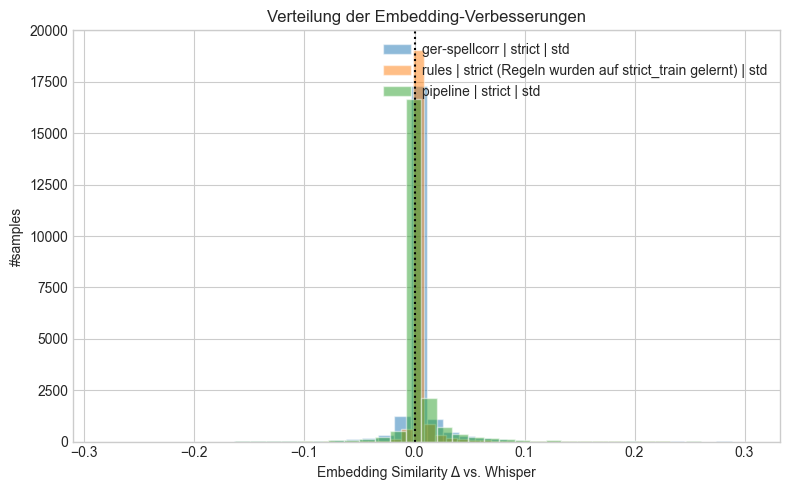

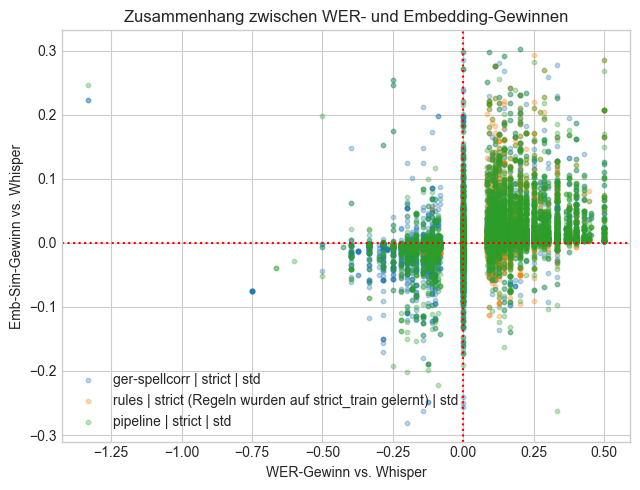

In [50]:
base_emb_col = "emb_sim_whisper"
gain_entries: list[tuple[str, str]] = []

for key in available_targets:
    if key == BASELINE_KEY:
        continue
    emb_col = f"emb_sim_{key}"
    if emb_col not in agg_df:
        continue
    gain_col = f"emb_gain_{key}"
    agg_df[gain_col] = agg_df[emb_col] - agg_df[base_emb_col]
    gain_entries.append((key, gain_col))

plt.figure(figsize=(8, 5))
for key, gain_col in gain_entries:
    label = systems_df.loc[key, "label"]
    plt.hist(agg_df[gain_col], bins=40, alpha=0.5, label=label)
plt.axvline(0, color="black", linestyle=":")
plt.xlabel("Embedding Similarity Δ vs. Whisper")
plt.ylabel("#samples")
plt.title("Verteilung der Embedding-Verbesserungen")
plt.legend()
plt.tight_layout()
plt.show()

if gain_entries:
    plt.figure(figsize=(6.5, 5))
    baseline_wer = get_wer_series(BASELINE_KEY)
    for key, gain_col in gain_entries:
        wer_gain = baseline_wer - get_wer_series(key)
        label = systems_df.loc[key, "label"]
        plt.scatter(wer_gain, agg_df[gain_col], s=10, alpha=0.3, label=label)
    plt.axvline(0, color="red", linestyle=":")
    plt.axhline(0, color="red", linestyle=":")
    plt.xlabel("WER-Gewinn vs. Whisper")
    plt.ylabel("Emb-Sim-Gewinn vs. Whisper")
    plt.title("Zusammenhang zwischen WER- und Embedding-Gewinnen")
    plt.legend()
    plt.tight_layout()
    plt.show()



### Beispiele für Embedding-Verbesserungen/Verschlechterungen


In [51]:
def extract_embedding_examples(pred_key: str, best: bool = True, n: int = 5) -> pd.DataFrame:
    emb_col = f"emb_sim_{pred_key}"
    if emb_col not in agg_df:
        raise ValueError(f"Keine Embedding-Spalte für {pred_key}")
    baseline_emb = agg_df["emb_sim_whisper"]
    model_emb = agg_df[emb_col]
    delta = model_emb - baseline_emb
    order = delta.sort_values(ascending=not best)
    indices = order.head(n).index
    meta = systems_df.loc[pred_key]
    baseline_meta = systems_df.loc[BASELINE_KEY]
    subset = agg_df.loc[indices, [
        REF_COLUMN,
        baseline_meta["output_col"],
        meta["output_col"],
        baseline_meta["wer_column"],
        meta["wer_column"],
        "emb_sim_whisper",
        emb_col,
    ]].copy()
    subset.rename(
        columns={
            REF_COLUMN: "reference",
            baseline_meta["output_col"]: "whisper",
            meta["output_col"]: meta["label"],
            baseline_meta["wer_column"]: "WER_whisper",
            meta["wer_column"]: f"WER_{pred_key}",
            "emb_sim_whisper": "emb_sim_whisper",
            emb_col: f"emb_sim_{pred_key}",
        },
        inplace=True,
    )
    subset["emb_gain"] = delta.loc[indices]
    subset["wer_gain"] = (get_wer_series(BASELINE_KEY) - get_wer_series(pred_key)).loc[indices]
    return subset

example_targets = [
    "ger-spellcorr-base_strict",
    "rules",
    "rules-tx",
]

for key in example_targets:
    if f"emb_sim_{key}" not in agg_df.columns:
        continue
    print(f"Top Embedding improvements for {systems_df.loc[key, 'label']}:")
    display(extract_embedding_examples(key, best=True))
    print(f"\nLargest Embedding regressions for {systems_df.loc[key, 'label']}:")
    display(extract_embedding_examples(key, best=False))


Top Embedding improvements for ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict,emb_sim_whisper,emb_sim_ger-spellcorr-base_strict,emb_gain,wer_gain
13841,oder ist es eine steuer,oder ist es ein stier,oder ist es ein steuer,0.400000,0.200000,0.696880,0.999892,0.303012,0.200000
19006,reich wäre er damit allerdings auch nicht geworden,riech werden damit allerdings auch nicht worte,reich werden damit allerdings auch nicht die worte,0.500000,0.500000,0.593669,0.892815,0.299146,0.000000
1632,die kapazitäten der schule seien damit bei weitem noch nicht ausgeschöpft,die kapazität der schuhe ist noch bei weitem nicht ausgeschöpft,die kapazität der schule ist noch bei weitem nicht ausgeschöpft,0.454545,0.363636,0.694459,0.992954,0.298494,0.090909
18156,das führt zwingend zu einem geringeren wachstum,das vier zwingend zu einem geringeren wachstopp,das führe zwingend zu einem geringeren wachstum,0.285714,0.142857,0.696174,0.988271,0.292097,0.142857
9690,steuererhöhungen sind bekanntlich unpopulär,störerheuge sind bekanntlich unpopulär,die steuererhöhungen sind bekanntlich unpopulär,0.250000,0.250000,0.712545,0.998520,0.285975,0.000000



Largest Embedding regressions for ger-spellcorr | strict | std:


,reference,whisper,ger-spellcorr | strict | std,WER_whisper,WER_ger-spellcorr-base_strict,emb_sim_whisper,emb_sim_ger-spellcorr-base_strict,emb_gain,wer_gain
2168,aber es war ein puma,aber es war ein puma,aber es war ein bauma,0.000000,0.200000,1.000000,0.718932,-0.281068,-0.200000
18663,wir folgen ihr in den ersten stock,wir folgen ihr in der südstock,wie folgen sie in den südosten,0.428571,0.571429,0.899939,0.637005,-0.262934,-0.142857
12941,aber es war ein puma,aber es ist in puma,aber es ist ein bauma,0.400000,0.400000,0.937555,0.680692,-0.256863,0.000000
2514,jetzt nähert sich die trumpära ihrem ende,jetzt nähert sich die trumpärie am ende,jetzt nähert sich die rumänien dem ende,0.285714,0.285714,0.989613,0.739692,-0.249921,0.000000
6539,es sollte auch ein anreiz sein zu arbeiten,es soll auch eine anreize sein zu arbeiten,es soll auch eine anreise sein zu schaffen,0.375000,0.500000,0.993342,0.744472,-0.248869,-0.125000


Top Embedding improvements for rules | strict (Regeln wurden auf strict_train gelernt) | std:


,reference,whisper,rules | strict (Regeln wurden auf strict_train gelernt) | std,WER_whisper,WER_rules,emb_sim_whisper,emb_sim_rules,emb_gain,wer_gain
8386,in wettingen läuft lowa,in mettingen läuft lowa,in wettingen läuft lowa,0.250000,0.0,0.706949,1.0,0.293051,0.250000
10116,bespielt wird sie von den akteuren aus dem wirklichen leben,bespielt wird die ski von den akteuren in unserem wirklichen labo,bespielt wird sie von den akteuren aus dem wirklichen leben,0.500000,0.0,0.714400,1.0,0.285600,0.500000
13713,aber auch im eishockey haben sich die zeiten gewandelt,aber auch im isokei haben sich die zeiten gewandelt,aber auch im eishockey haben sich die zeiten gewandelt,0.111111,0.0,0.723142,1.0,0.276858,0.111111
21128,aber auch im eishockey haben sich die zeiten gewandelt,aber auch im isokei haben sich die zeiten gewandelt,aber auch im eishockey haben sich die zeiten gewandelt,0.111111,0.0,0.723142,1.0,0.276858,0.111111
6668,gute noten erhält aber auch die migros,gute noten bekommt aber auch die mikro,gute noten erhält aber auch die migros,0.285714,0.0,0.729526,1.0,0.270474,0.285714



Largest Embedding regressions for rules | strict (Regeln wurden auf strict_train gelernt) | std:


,reference,whisper,rules | strict (Regeln wurden auf strict_train gelernt) | std,WER_whisper,WER_rules,emb_sim_whisper,emb_sim_rules,emb_gain,wer_gain
21662,sie sollen künftig 17mal höher sein als heute,sie sollte künftig 17 mal höher sein als heute,sie sollte künftig 1siebenmal höher sein als heute,0.375000,0.250000,0.977479,0.863930,-0.113549,0.125000
3793,letzte woche ist michael oberer im alter von 65 jahren gestorben,letzte woche starb michael oberer im alter von 65 jahren,letzte woche ist michael oberer im alter von 65 jahren,0.181818,0.090909,0.995602,0.883430,-0.112172,0.090909
21418,letzte woche ist michael oberer im alter von 65 jahren gestorben,letzte woche starb michael oberer im alter von 65 jahren,letzte woche ist michael oberer im alter von 65 jahren,0.181818,0.090909,0.995602,0.883430,-0.112172,0.090909
21647,letzte woche ist michael oberer im alter von 65 jahren gestorben,nächste woche starb michael operer im alter von 65 jahren,nächste woche ist michael operer im alter von 65 jahren,0.363636,0.272727,0.881886,0.782053,-0.099833,0.090909
707,auch neuwahlen lehnte er ab,auch neuwahlen hat er abgelehnt,auch neuwahlen hat er ab,0.400000,0.200000,0.996479,0.901454,-0.095026,0.200000


Top Embedding improvements for pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_rules-tx,emb_sim_whisper,emb_sim_rules-tx,emb_gain,wer_gain
13841,oder ist es eine steuer,oder ist es ein stier,oder ist es ein steuer,0.400000,0.200000,0.696880,0.999892,0.303012,0.200000
19006,reich wäre er damit allerdings auch nicht geworden,riech werden damit allerdings auch nicht worte,reich werden damit allerdings auch nicht die worte,0.500000,0.500000,0.593669,0.892815,0.299146,0.000000
1632,die kapazitäten der schule seien damit bei weitem noch nicht ausgeschöpft,die kapazität der schuhe ist noch bei weitem nicht ausgeschöpft,die kapazitäten der schulen sind noch bei weitem nicht ausgeschöpft,0.454545,0.363636,0.694459,0.992304,0.297845,0.090909
18156,das führt zwingend zu einem geringeren wachstum,das vier zwingend zu einem geringeren wachstopp,das führe zwingend zu einem geringeren wachstum,0.285714,0.142857,0.696174,0.988271,0.292097,0.142857
10116,bespielt wird sie von den akteuren aus dem wirklichen leben,bespielt wird die ski von den akteuren in unserem wirklichen labo,bespielt wird sie von den akteuren aus dem wirklichen leben,0.500000,0.000000,0.714400,1.000000,0.285600,0.500000



Largest Embedding regressions for pipeline | strict | std:


,reference,whisper,pipeline | strict | std,WER_whisper,WER_rules-tx,emb_sim_whisper,emb_sim_rules-tx,emb_gain,wer_gain
20028,das wort geht an die fraktion,das wort geht ad fraction,das wort geht an die familie,0.500000,0.166667,0.947180,0.684870,-0.262311,0.333333
10442,die cvp lehnt den antrag um erweiterung auf 20 tage ab,cvp lehnt radlagerumweiterung auf 20 tage ab,die cvp lehnt die ranglage um weite dauernd ab,0.454545,0.545455,0.954895,0.732290,-0.222605,-0.090909
2168,aber es war ein puma,aber es war ein puma,aber es war ein baum,0.000000,0.200000,1.000000,0.797845,-0.202155,-0.200000
13140,von einem emboom will man jedoch nichts wissen,von einem emboom will man jedoch nichts wissen,von einem embargo will man jedoch nichts wissen,0.000000,0.125000,1.000000,0.800915,-0.199085,-0.125000
17453,auch das verstehen wir,aber das verstehen wir,aber das verstehen wir nicht,0.250000,0.500000,0.989104,0.796741,-0.192363,-0.250000



## Weiteres Vorgehen
* Die DataFrame `agg_df` enthält nun zusätzlich Spalten `WER_*` sowie `emb_sim_*` und kann für beliebige Filter- oder Drill-down-Analysen genutzt werden (z. B. Dialekt, Länge, Confidence).
* Über die Helper `extract_wer_examples` und `extract_embedding_examples` lassen sich weitere Modelle gezielt inspizieren – einfach `pred_key` (laut Tabelle oben) anpassen.
